In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init

import random
import time
import math
from tempfile import TemporaryFile
from dateutil import parser

In [108]:
# post processing our data
from dateutil import parser

final_df = pd.DataFrame([])

date_list = ['2021-12-01','2021-12-02','2021-12-03','2021-12-04','2021-12-05','2021-12-06','2021-12-07']

for date in date_list:
    temp_df = pd.read_csv(f'data/Synthetic Site/Synthetic Site Predictors {date}.csv')
    temp_output = pd.read_csv(f'data/Synthetic Site/Synthetic Site Targets {date}.csv')

    temp_df['Timestamp'] = temp_df['Timestamp'].map(lambda x: parser.parse(x[0:-13]))

    processed_df =  temp_df.iloc[:,1:].astype(float)
    
#     processed_df['year'] = temp_df['Timestamp'].map(lambda x: float(x.year))
#     processed_df['month_of_yr'] =  temp_df['Timestamp'].map(lambda x: float(x.month))
#     processed_df['day_of_yr'] =  temp_df['Timestamp'].map(lambda x: float(x.timetuple().tm_yday))
#     processed_df['day_of_month'] =  temp_df['Timestamp'].map(lambda x: float(x.day))
    processed_df['day_of_week'] =  temp_df['Timestamp'].map(lambda x: float(x.weekday()))
    processed_df['weekend'] =  processed_df['day_of_week'].map(lambda x: float(x>4))
    processed_df['hour'] =  temp_df['Timestamp'].map(lambda x: float(x.hour))
    processed_df['minute'] =  temp_df['Timestamp'].map(lambda x: float(x.minute))

    processed_df['usage'] =  temp_output['Synthetic Site Electricity Main Total Power'].astype(float)

    final_df = pd.concat([final_df, processed_df], axis = 0)
    
final_df = final_df.dropna()
final_df = final_df.reset_index(drop = True)

final_df.to_csv('data/Synthetic Site_dataset_2.csv', index = None)

In [109]:
#########################################################################################
# building the S2S model
class S2S_Model(nn.Module):
    def __init__(self, cell_type, input_size, hidden_size, use_cuda):
        super(S2S_Model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.cell_type = cell_type

        if self.cell_type not in ['rnn', 'gru', 'lstm']:
            raise ValueError(self.cell_type, " is not an appropriate cell type. Please select one of rnn, gru, or lstm.")
        if self.cell_type == 'rnn':
            self.Ecell = nn.RNNCell(self.input_size, self.hidden_size)
            self.Dcell = nn.RNNCell(1, self.hidden_size)
        if self.cell_type == 'gru':
            self.Ecell = nn.GRUCell(self.input_size, self.hidden_size)
            self.Dcell = nn.GRUCell(1, self.hidden_size)
        if self.cell_type == 'lstm':
            self.Ecell = nn.LSTMCell(self.input_size, self.hidden_size)
            self.Dcell = nn.LSTMCell(1, self.hidden_size)

        self.lin_usage = nn.Linear(self.hidden_size, 1)
        self.use_cuda = use_cuda
        self.init()

    # function to intialize weight parameters. Refer to Saxe at al. paper that explains why to use orthogonal init weights
    def init(self):
        if self.cell_type == 'rnn' or self.cell_type == 'gru':
            for p in self.parameters():
                if p.dim() > 1:
                    init.orthogonal_(p.data, gain=1.0)
                if p.dim() == 1:
                    init.constant_(p.data, 0.0)
        elif self.cell_type == 'lstm':
            for p in self.parameters():
                if p.dim() > 1:
                    init.orthogonal_(p.data, gain=1.0)
                if p.dim() == 1:
                    init.constant_(p.data, 0.0)
                    init.constant_(p.data[self.hidden_size:2*self.hidden_size], 1.0)

    def consume(self, x):
        # encoder forward function
        # for rnn and gru
        if self.cell_type == 'rnn' or self.cell_type == 'gru':
            h = torch.zeros(x.shape[0], self.hidden_size)
            if self.use_cuda:
                h = h.cuda()
            for T in range(x.shape[1]):
                h = self.Ecell(x[:, T, :], h)
            pred_usage = self.lin_usage(h)
        # for lstm
        elif self.cell_type == 'lstm':
            h0 = torch.zeros(x.shape[0], self.hidden_size)
            c0 = torch.zeros(x.shape[0], self.hidden_size)
            if self.use_cuda:
                h0 = h0.cuda()
                c0 = c0.cuda()
            h = (h0, c0)
            for T in range(x.shape[1]):
                h = self.Ecell(x[:, T, :], h)
            pred_usage = self.lin_usage(h[0])
        return pred_usage, h

    def predict(self, pred_usage, h, target_length):
        # decoder forward function
        preds = []
        # for rnn and gru
        if self.cell_type == 'rnn' or self.cell_type == 'gru':
            for step in range(target_length):
                h = self.Dcell(pred_usage, h)
                pred_usage = self.lin_usage(h)
                preds.append(pred_usage.unsqueeze(1))
            preds = torch.cat(preds, 1)
        # for lstm
        elif self.cell_type == 'lstm':
            for step in range(target_length):
                h = self.Dcell(pred_usage, h)
                pred_usage = self.lin_usage(h[0])
                preds.append(pred_usage.unsqueeze(1))
            preds = torch.cat(preds, 1)
        return preds

#########################################################################################
# Bahdanau Attention model
# refer to : AuCson github code
# building the model
class S2S_BA_Model(nn.Module):
    def __init__(self, cell_type, input_size, hidden_size, use_cuda):
        super(S2S_BA_Model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.use_cuda = use_cuda
        self.cell_type = cell_type

        if self.cell_type not in ['rnn', 'gru', 'lstm']:
            raise ValueError(self.cell_type, " is not an appropriate cell type. Please select one of rnn, gru, or lstm.")
        if self.cell_type == 'rnn':
            self.Ecell = nn.RNNCell(self.input_size, self.hidden_size)
            self.Dcell = nn.RNNCell(1+self.hidden_size, self.hidden_size)
        if self.cell_type == 'gru':
            self.Ecell = nn.GRUCell(self.input_size, self.hidden_size)
            self.Dcell = nn.GRUCell(1+self.hidden_size, self.hidden_size)
        if self.cell_type == 'lstm':
            self.Ecell = nn.LSTMCell(self.input_size, self.hidden_size)
            self.Dcell = nn.LSTMCell(1+self.hidden_size, self.hidden_size)

        self.Wattn_energies = nn.Linear(self.hidden_size*2, self.hidden_size)
        self.Wusage = nn.Linear(self.hidden_size, 1)
        self.Wout = nn.Linear(1+self.hidden_size*2, self.hidden_size)
        self.v = nn.Parameter(torch.rand(self.hidden_size))
        stdv = 1./math.sqrt(self.v.size(0))
        self.v.data.normal_(mean=0, std=stdv)
        self.init()

# function to intialize weight parameters
    def init(self):
        if self.cell_type == 'rnn' or self.cell_type == 'gru':
            for p in self.parameters():
                if p.dim() > 1:
                    init.orthogonal_(p.data, gain=1.0)
                if p.dim() == 1:
                    init.constant_(p.data, 0.0)
        elif self.cell_type == 'lstm':
            for p in self.parameters():
                if p.dim() > 1:
                    init.orthogonal_(p.data, gain=1.0)
                if p.dim() == 1:
                    init.constant_(p.data, 0.0)
                    init.constant_(p.data[self.hidden_size:2*self.hidden_size], 1.0)

    def consume(self, x):
        # for rnn and gru
        if self.cell_type == 'rnn' or self.cell_type == 'gru':
            # encoder forward function
            h = torch.zeros(x.shape[0], self.hidden_size)
            encoder_outputs = torch.zeros(x.shape[1], x.shape[0], self.hidden_size)
            if self.use_cuda:
                h = h.cuda()
                encoder_outputs = encoder_outputs.cuda()
            # encoder part
            for T in range(x.shape[1]):
                h = self.Ecell(x[:, T, :], h)
                encoder_outputs[T] = h
            pred_usage = self.Wusage(h)
        # for lstm
        elif self.cell_type == 'lstm':
            h0 = torch.zeros(x.shape[0], self.hidden_size)
            c0 = torch.zeros(x.shape[0], self.hidden_size)
            encoder_outputs = torch.zeros(x.shape[1], x.shape[0], self.hidden_size)
            if self.use_cuda:
                h0 = h0.cuda()
                c0 = c0.cuda()
                encoder_outputs = encoder_outputs.cuda()
            h = (h0, c0)
            for T in range(x.shape[1]):
                h = self.Ecell(x[:, T, :], h)
                encoder_outputs[T] = h[0]
            pred_usage = self.Wusage(h[0])
        return pred_usage, h, encoder_outputs

    def predict(self, pred_usage, h, encoder_outputs, target_length):
        # decoder with attention function
        preds = []
        # for rnn and gru
        if self.cell_type == 'rnn' or self.cell_type == 'gru':
            for step in range(target_length):
                h_copies = h.expand(encoder_outputs.shape[0], -1, -1)
                energies = torch.tanh(self.Wattn_energies(torch.cat((h_copies, encoder_outputs), 2)))
                score = torch.sum(self.v * energies, dim=2)
                attn_weights = score.t()
                attn_weights = torch.softmax(attn_weights, dim=1).unsqueeze(1)
                context = attn_weights.bmm(encoder_outputs.transpose(0,1)).squeeze(1)
                gru_input = torch.cat((pred_usage, context), 1)
                h = self.Dcell(gru_input, h)
                output = self.Wout(torch.cat((pred_usage, h, context), 1))
                pred_usage = self.Wusage(output)
                preds.append(pred_usage.unsqueeze(1))
            preds = torch.cat(preds, 1)
        # for lstm
        elif self.cell_type == 'lstm':
            for step in range(target_length):
                h_copies = h[0].expand(encoder_outputs.shape[0], -1, -1)
                energies = torch.tanh(self.Wattn_energies(torch.cat((h_copies, encoder_outputs), 2)))
                score = torch.sum(self.v * energies, dim=2)
                attn_weights = score.t()
                attn_weights = torch.softmax(attn_weights, dim=1).unsqueeze(1)
                context = attn_weights.bmm(encoder_outputs.transpose(0,1)).squeeze(1)
                gru_input = torch.cat((pred_usage, context), 1)
                h = self.Dcell(gru_input, h)
                output = self.Wout(torch.cat((pred_usage, h[0], context), 1))
                pred_usage = self.Wusage(output)
                preds.append(pred_usage.unsqueeze(1))
            preds = torch.cat(preds, 1)
        return preds

#############################################################################################3
# Luong Attention module
class Attn(torch.nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, " is not an appropriate attention method, please select one of dot, general, or concat.")
        self.hidden_size = hidden_size
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, self.hidden_size)
        if self.method == 'concat':
            self.attn = nn.Linear(2*self.hidden_size, self.hidden_size)
            self.v = nn.Parameter(torch.rand(self.hidden_size))
            stdv = 1./math.sqrt(self.v.size(0))
            self.v.data.normal_(mean=0, std=stdv)

    def dot_score(self, hidden, encoder_output):
        attn_energies = torch.sum(hidden*encoder_output, dim=2)
        return attn_energies

    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        attn_energies = torch.sum(hidden*energy, dim=2)
        return attn_energies

    def concat_score(self, hidden, encoder_output):
        energy = torch.tanh(self.attn(torch.cat((hidden.expand(encoder_output.shape[0], -1, -1),
                            encoder_output), 2)))
        return torch.sum(self.v * energy, dim=2)

    # calculate the attention weights (energies) based on the given method
    def forward(self, hidden, encoder_outputs):
        if self.method == 'dot':
            attn_energies = self.dot_score(hidden, encoder_outputs)
        elif self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        attn_energies = attn_energies.t()
        attn_weights = torch.softmax(attn_energies, dim=1).unsqueeze(1)
        return attn_weights

#########################################################################################
#  building the S2S LA model
class S2S_LA_Model(nn.Module):
    def __init__(self, cell_type, attn_method, input_size, hidden_size, use_cuda):
        super(S2S_LA_Model, self).__init__()
        self.cell_type = cell_type
        self.attn_method = attn_method
        self.input_size = input_size
        self.hidden_size = hidden_size

        if self.cell_type == 'rnn':
            self.Ecell = nn.RNNCell(self.input_size, self.hidden_size)
            self.Dcell = nn.RNNCell(1, self.hidden_size)
        if self.cell_type == 'gru':
            self.Ecell = nn.GRUCell(self.input_size, self.hidden_size)
            self.Dcell = nn.GRUCell(1, self.hidden_size)
        if self.cell_type == 'lstm':
            self.Ecell = nn.LSTMCell(self.input_size, self.hidden_size)
            self.Dcell = nn.LSTMCell(1, self.hidden_size)

        self.lin_usage = nn.Linear(hidden_size, 1)
        self.lin_concat = nn.Linear(hidden_size*2, hidden_size)
        self.attn = Attn(self.attn_method, self.hidden_size)
        self.use_cuda = use_cuda
        self.init()

    # function to intialize weight parameters
    def init(self):
        if self.cell_type == 'rnn' or self.cell_type == 'gru':
            for p in self.parameters():
                if p.dim() > 1:
                    init.orthogonal_(p.data, gain=1.0)
                if p.dim() == 1:
                    init.constant_(p.data, 0.0)
        elif self.cell_type == 'lstm':
            for p in self.parameters():
                if p.dim() > 1:
                    init.orthogonal_(p.data, gain=1.0)
                if p.dim() == 1:
                    init.constant_(p.data, 0.0)
                    init.constant_(p.data[self.hidden_size:2*self.hidden_size], 1.0)

    def consume(self, x):
        if self.cell_type == 'rnn' or self.cell_type == 'gru':
            # encoder forward function
            h = torch.zeros(x.shape[0], self.hidden_size)
            encoder_outputs = torch.zeros(x.shape[1], x.shape[0], self.hidden_size)
            if self.use_cuda:
                h = h.cuda()
                encoder_outputs = encoder_outputs.cuda()
            # encoder part
            for T in range(x.shape[1]):
                h = self.Ecell(x[:, T, :], h)
                encoder_outputs[T] = h
            pred_usage = self.lin_usage(h)
        elif self.cell_type == 'lstm':
            h0 = torch.zeros(x.shape[0], self.hidden_size)
            c0 = torch.zeros(x.shape[0], self.hidden_size)
            encoder_outputs = torch.zeros(x.shape[1], x.shape[0], self.hidden_size)
            if self.use_cuda:
                h0 = h0.cuda()
                c0 = c0.cuda()
                encoder_outputs = encoder_outputs.cuda()
            h = (h0, c0)
            for T in range(x.shape[1]):
                h = self.Ecell(x[:, T, :], h)
                encoder_outputs[T] = h[0]
            pred_usage = self.lin_usage(h[0])
        return pred_usage, h, encoder_outputs

    def predict(self, pred_usage, h, encoder_outputs, target_length):
        # decoder with attention function
        preds = []
        if self.cell_type == 'rnn' or self.cell_type == 'gru':
            for step in range(target_length):
                h = self.Dcell(pred_usage, h)
                attn_weights = self.attn(h, encoder_outputs)
                context = attn_weights.bmm(encoder_outputs.transpose(0,1))
                context = context.squeeze(1)
                concat_input = torch.cat((h, context), 1)
                concat_output = torch.tanh(self.lin_concat(concat_input))
                pred_usage = self.lin_usage(concat_output)
                preds.append(pred_usage.unsqueeze(1))
            preds = torch.cat(preds, 1)
        elif self.cell_type == 'lstm':
            for step in range(target_length):
                h = self.Dcell(pred_usage, h)
                attn_weights = self.attn(h[0], encoder_outputs)
                context = attn_weights.bmm(encoder_outputs.transpose(0,1))
                context = context.squeeze(1)
                concat_input = torch.cat((h[0], context), 1)
                concat_output = torch.tanh(self.lin_concat(concat_input))
                pred_usage = self.lin_usage(concat_output)
                preds.append(pred_usage.unsqueeze(1))
            preds = torch.cat(preds, 1)
        return preds

#################################################################################################################################################
# main function
def main(seed, cuda, cell_type, attention_model, la_method, window_source_size,
            window_target_size, epochs, batch_size, hs, save_model):
    t0 = time.time()
    np.random.seed(seed)
    torch.manual_seed(seed)
    print("Loading dataset...")
#     d = np.loadtxt("data/Synthetic Site_dataset_2.csv", delimiter=",", skiprows=1, dtype=float)
#     # removing unneeded columns
#     dataset = d[:, 1:].astype(np.float32)
#     dataset = pd.DataFrame(dataset)
#     dataset.columns = ['month_of_yr', 'day_of_yr','day_of_month', 'season','day_of_week', 'weekend', 'holiday', 'hour', 'minute', 'temp', 'hum', 'usage']
# #     dataset = pd.read_csv("data/Synthetic Site_dataset.csv")
# #     dataset = dataset.astype(np.float32)
#     # switch around columns
# #     dataset = dataset[['month_of_yr', 'day_of_yr','day_of_month', 'season',
# #              'day_of_week', 'weekend', 'holiday', 'hour', 'minute', 'temp', 'hum', 'usage']]
#     dataset = dataset[['month_of_yr', 'day_of_yr','temp', 'hum', 'usage']]
# #     dataset = dataset.drop('minute',1).drop('temp',1).drop('hum',1)

    dataset = pd.read_csv("data/Synthetic Site_dataset_2.csv").astype(np.float32)
    usage_actual = dataset['usage']
    mu_usage = dataset['usage'].mean()
    std_usage = dataset['usage'].std()
    dataset = dataset.values

    # 0 mean and unit var
    print("Transforming data to 0 mean and unit var")
    MU = dataset.mean(0) # 0 means take the mean of the column
    dataset = dataset - MU
    STD = dataset.std(0) # same with std here
    dataset = dataset / STD

    # 5 minutes between rows.
    # use 1 hour (12 rows) to predict next half hour (6 rows)
    print("Generating training and test data...")
    WINDOW_SOURCE_SIZE = window_source_size
    WINDOW_TARGET_SIZE = window_target_size

    # getting actual usage vector, aligning with predicted values vector. Aka remove first window_source_size and remaining
    usage_actual = usage_actual.values
    usage_actual = usage_actual[int(dataset.shape[0]*0.80):]
    usage_actual = usage_actual[WINDOW_SOURCE_SIZE:]

    # 80% train, 20% test
    train_source = dataset[:int(dataset.shape[0]*0.80)]
    test_source = dataset[int(dataset.shape[0]*0.80):]

    # if N = data.shape[0] - (WINDOW_SOURCE_SIZE+WINDOW_TARGET_SIZE)
    # then you will be sliding over every one

    def generate_windows(data):
        x_train = []
        y_usage_train = []
        x_test = []
        y_usage_test = []

        # for training data
        idxs = np.random.choice(train_source.shape[0]-(WINDOW_SOURCE_SIZE+WINDOW_TARGET_SIZE), train_source.shape[0]-(WINDOW_SOURCE_SIZE+WINDOW_TARGET_SIZE), replace=False)

        for idx in idxs:
            x_train.append(train_source[idx:idx+WINDOW_SOURCE_SIZE].reshape((1, WINDOW_SOURCE_SIZE, train_source.shape[1])) )
            y_usage_train.append(train_source[idx+WINDOW_SOURCE_SIZE:idx+WINDOW_SOURCE_SIZE+WINDOW_TARGET_SIZE, -1].reshape((1, WINDOW_TARGET_SIZE, 1)) )

        x_train = np.concatenate(x_train, axis=0) # make them arrays and not lists
        y_usage_train = np.concatenate(y_usage_train, axis=0)

        # for testing data
        idxs = np.arange(0, len(test_source)-(WINDOW_SOURCE_SIZE+WINDOW_TARGET_SIZE), WINDOW_TARGET_SIZE)

        for idx in idxs:
            x_test.append(test_source[idx:idx+WINDOW_SOURCE_SIZE].reshape((1, WINDOW_SOURCE_SIZE, test_source.shape[1])) )
            y_usage_test.append(test_source[idx+WINDOW_SOURCE_SIZE:idx+WINDOW_SOURCE_SIZE+WINDOW_TARGET_SIZE, -1].reshape((1, WINDOW_TARGET_SIZE, 1)) )

        x_test = np.concatenate(x_test, axis=0) # make them arrays and not lists
        y_usage_test = np.concatenate(y_usage_test, axis=0)

        return x_train, y_usage_train, x_test, y_usage_test

    X_train, Y_train_usage, X_test, Y_test_usage = generate_windows(dataset)
    print("Created {} train samples and {} test samples".format(X_train.shape[0], X_test.shape[0]))
    idxs = np.arange(0, len(test_source)-(WINDOW_SOURCE_SIZE+WINDOW_TARGET_SIZE), WINDOW_TARGET_SIZE)
    remainder = len(test_source) - (idxs[-1] + WINDOW_SOURCE_SIZE+WINDOW_TARGET_SIZE)
    usage_actual = usage_actual[:-remainder]

#################################################################################################################################################
# call the model
    #print("Creating model...")
    INPUT_SIZE = X_train.shape[-1]
    HIDDEN_SIZE = hs
    CELL_TYPE = cell_type
    LA_METHOD = la_method

    # call the respective model
    if attention_model == 'none':
        model = S2S_Model(CELL_TYPE, INPUT_SIZE, HIDDEN_SIZE, use_cuda=cuda)

    elif attention_model == 'BA':
        model = S2S_BA_Model(CELL_TYPE, INPUT_SIZE, HIDDEN_SIZE, use_cuda=cuda)

    elif attention_model == 'LA':
        model = S2S_LA_Model(CELL_TYPE, LA_METHOD, INPUT_SIZE, HIDDEN_SIZE, use_cuda=cuda)

    if cuda:
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        model.cuda()

    print("MODEL ARCHITECTURE IS: ")
    print(model)

    print("\nModel parameters are on cuda: {}".format(next(model.parameters()).is_cuda))

    opt = optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss(reduction='sum')
    EPOCHES = epochs
    BATCH_SIZE = batch_size

    print("\nStarting training...")

    train_loss = []
    test_loss = []

    for epoch in range(EPOCHES):
        t_one_epoch = time.time()
        print("Epoch {}".format(epoch+1))
        total_usage_loss = 0
        for b_idx in range(0, X_train.shape[0], BATCH_SIZE):

            x = torch.from_numpy(X_train[b_idx:b_idx+BATCH_SIZE]).float()
            y_usage = torch.from_numpy(Y_train_usage[b_idx:b_idx+BATCH_SIZE]).float()

            if cuda:
                x = x.cuda()
                y_usage = y_usage.cuda()

            # encoder forward, for respective models (with and without attention)
            if attention_model == 'none':
                pred_usage, h = model.consume(x)

            elif attention_model == 'BA':
                pred_usage, h, encoder_outputs = model.consume(x)

            elif attention_model == 'LA':
                pred_usage, h, encoder_outputs = model.consume(x)

            # decoder forward, for respective models
            if attention_model == 'none':
                preds = model.predict(pred_usage, h, WINDOW_TARGET_SIZE)

            elif attention_model == 'BA':
                preds = model.predict(pred_usage, h, encoder_outputs, WINDOW_TARGET_SIZE)

            elif attention_model == 'LA':
                preds = model.predict(pred_usage, h, encoder_outputs, WINDOW_TARGET_SIZE)

            # compute lose
            loss_usage = loss_fn(preds, y_usage)

            # backprop and update
            opt.zero_grad()

            loss_usage.backward()

            opt.step()

            total_usage_loss += loss_usage.item()
            
        train_loss.append(total_usage_loss)
        print("\tTRAINING: {} total train USAGE loss.\n".format(total_usage_loss))

#################################################################################################################################################
# TESTING
        y_usage = None
        pred_usage = None
        preds = None
        total_usage_loss = 0
        all_preds = []

        for b_idx in range(0, X_test.shape[0], BATCH_SIZE):
            with torch.no_grad():
                x = torch.from_numpy(X_test[b_idx:b_idx+BATCH_SIZE])
                y_usage = torch.from_numpy(Y_test_usage[b_idx:b_idx+BATCH_SIZE])

                if cuda:
                    x = x.cuda()
                    y_usage = y_usage.cuda()

                # encoder forward, for respective models
                if attention_model == 'none':
                    pred_usage, h = model.consume(x)

                elif attention_model == 'BA':
                    pred_usage, h, encoder_outputs = model.consume(x)

                elif attention_model == 'LA':
                    pred_usage, h, encoder_outputs = model.consume(x)

                # decoder forward, for respective models
                if attention_model == 'none':
                    preds = model.predict(pred_usage, h, WINDOW_TARGET_SIZE)

                elif attention_model == 'BA':
                    preds = model.predict(pred_usage, h, encoder_outputs, WINDOW_TARGET_SIZE)

                elif attention_model == 'LA':
                    preds = model.predict(pred_usage, h, encoder_outputs, WINDOW_TARGET_SIZE)

                # compute loss
                loss_usage = loss_fn(preds, y_usage)

                total_usage_loss += loss_usage.item()

                if (epoch == epochs-1):
                    all_preds.append(preds)

        test_loss.append(total_usage_loss)

        print("\tTESTING: {} total test USAGE loss".format(total_usage_loss))
        print("\tTESTING:\n")
        print("\tSample of prediction:")
        print("\t\t TARGET: {}".format(y_usage[-1].cpu().detach().numpy().flatten()))
        print("\t\t   PRED: {}\n\n".format(preds[-1].cpu().detach().numpy().flatten()))

        y_last_usage = y_usage[-1].cpu().detach().numpy().flatten()
        pred_last_usage = preds[-1].cpu().detach().numpy().flatten()
        t2_one_epoch = time.time()
        time_one_epoch = t2_one_epoch - t_one_epoch
        print("TIME OF ONE EPOCH: {} seconds and {} minutes".format(time_one_epoch, time_one_epoch/60.0))

####################################################################################################
# SAVING MODEL
    if save_model:
        torch.save(model.state_dict(), "MODEL_w:__seed={}_cell_type={}_attention_model={}_la_method={}_T={}_N={}_bs={}_hs={}".format(
            seed, cell_type, attention_model, la_method,
            window_source_size, window_target_size, batch_size, hs))

#################################################################################################################################################
# PLOTTING
    # for plotting and accuracy
    preds = torch.cat(all_preds, 0)
    preds = preds.cpu().detach().numpy().flatten()
    actual = Y_test_usage.flatten()

    # for loss plotting
    train_loss_array = np.asarray(train_loss)
    test_loss_array = np.asarray(test_loss)
    len_loss = np.arange(len(train_loss_array))

    # unnormalizing 1
    preds_unnorm = (preds*std_usage) + mu_usage

    # using the actual usage from top of script here
    mae3 = (sum(abs(usage_actual - preds_unnorm)))/(len(usage_actual))
    mape3 = (sum(abs((usage_actual - preds_unnorm)/usage_actual)))/(len(usage_actual))

    # for std
    mape_s = (abs((usage_actual - preds_unnorm)/usage_actual))
    s = mape_s.std()
    mae_s = abs(usage_actual - preds_unnorm)
    s2 = mae_s.std()
    print("\n\tACTUAL ACC. RESULTS: MAE, MAPE: {} and {}%".format(mae3, mape3*100.0))

    # plotting
    plt.figure(1)
    plt.plot(np.arange(len(preds)), preds, 'b', label='Predicted')
    plt.plot(np.arange(len(actual)), actual, 'g', label='Actual')
    plt.title("Predicted vs Actual, {} timesteps to {} timesteps".format(window_source_size, window_target_size))
    plt.xlabel("Time in 5 minute increments")
    plt.ylabel("Usage (normalized)")
    plt.legend(loc='lower left')

#     plt.figure(2)
#     plt.plot(np.arange(len(actual)), actual, 'g', label='Actual')
#     plt.plot(np.arange(len(preds)), preds, 'b', label='Predicted')
#     plt.title("Predicted vs Actual, {} timesteps to {} timesteps".format(window_source_size, window_target_size))
#     plt.xlabel("Time in 5 minute increments")
#     plt.ylabel("Usage (normalized)")
#     plt.legend(loc='lower left')

#     plt.figure(3)
#     plt.plot(np.arange(len(y_last_usage)), y_last_usage, 'g', label='Actual')
#     plt.plot(np.arange(len(pred_last_usage)), pred_last_usage, 'b', label='Predicted')
#     plt.title("Predicted vs Actual last test example, {} timesteps to {} timesteps".format(window_source_size, window_target_size))
#     plt.xlabel("Time in 5 minute increments")
#     plt.ylabel("Usage (normalized)")
#     plt.legend(loc='lower left')

#     plt.figure(4)
#     plt.plot(np.arange(len(usage_actual[-12*24*7:])), usage_actual[-12*24*7:], 'g', label='Actual')
#     plt.plot(np.arange(len(preds_unnorm[-12*24*7:])), preds_unnorm[-12*24*7:], 'b', label='Predicted')
#     plt.title("Predicted vs Actual: Case 2, Zoom last 7 days".format(window_source_size, window_target_size))
#     plt.xlabel("Time in 5 minute increments")
#     plt.ylabel("Usage (kW)")
#     plt.legend(loc='lower left')

#     plt.figure(5)
#     plt.plot(len_loss, train_loss_array, 'k')
#     plt.title("Train loss")
#     plt.xlabel("Epoch")
#     plt.ylabel("Loss")

#     plt.figure(6)
#     plt.plot(len_loss, test_loss_array, 'r')
#     plt.title("Test Loss")
#     plt.xlabel("Epoch")
#     plt.ylabel("Loss")

    # total time of run
    t1 = time.time()
    total = t1-t0
    print("\nTIME ELAPSED: {} seconds OR {} minutes".format(total, total/60.0))
    print("\nEnd of run")
    plt.show()
    for_plotting = [usage_actual, preds_unnorm, y_last_usage, pred_last_usage]
    return s, s2, mape_s, mae_s, mae3, mape3, total/60.0, train_loss, test_loss, for_plotting

Loading dataset...
Transforming data to 0 mean and unit var
Generating training and test data...
Created 8042 train samples and 333 test samples
MODEL ARCHITECTURE IS: 
S2S_BA_Model(
  (Ecell): LSTMCell(12, 64)
  (Dcell): LSTMCell(65, 64)
  (Wattn_energies): Linear(in_features=128, out_features=64, bias=True)
  (Wusage): Linear(in_features=64, out_features=1, bias=True)
  (Wout): Linear(in_features=129, out_features=64, bias=True)
)

Model parameters are on cuda: True

Starting training...
Epoch 1
	TRAINING: 16491.279846191406 total train USAGE loss.

	TESTING: 566.5044422149658 total test USAGE loss
	TESTING:

	Sample of prediction:
		 TARGET: [ 0.0791177  -0.0031497  -0.04903844 -0.07976366 -0.10483488 -0.11744238]
		   PRED: [0.19033816 0.11567306 0.10172602 0.08471853 0.07042702 0.05816173]


TIME OF ONE EPOCH: 1.1166927814483643 seconds and 0.01861154635747274 minutes
Epoch 2
	TRAINING: 11371.650970458984 total train USAGE loss.

	TESTING: 540.8630867004395 total test USAGE loss
	

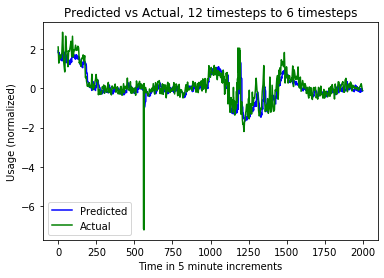

In [125]:
if __name__ == "__main__":
    s, s2, mape_s, mae_s, mae, mape, total_mins, train_loss, test_loss, for_plotting = main(seed=0, cuda=True,
        cell_type='lstm', attention_model='BA', la_method='none',
        window_source_size=12, window_target_size=6, epochs=2,
        batch_size=256, hs=64, save_model=False)